# Importing Modules

In [1]:
!pip install adjustText

  Preparing metadata (setup.py) ... - done
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=545393e3820092bbda442174f6852d5020995c6bae34e881f1ec159391e42863
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [2]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from adjustText import adjust_text

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading Data

In [3]:
# Available leagues in Understat
leagues = ['EPL', 'La_liga', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']

# Available seasons in Understat range from 2014/15 to Present
# Understat uses the year of the first half of the season as its indicator
seasons = [2014, 2015, 2016, 2017, 2018, 2018, 2020, 2021, 2022]

# For this project the 2021-2022 season of EPL is the main concern
base_url = 'https://understat.com/league/'
url = base_url + leagues[0] + '/' + str(seasons[-2])

From the page source it can be observed that the required data is in a script variable called 'playersData', which is the 4th item in the list of scripts.

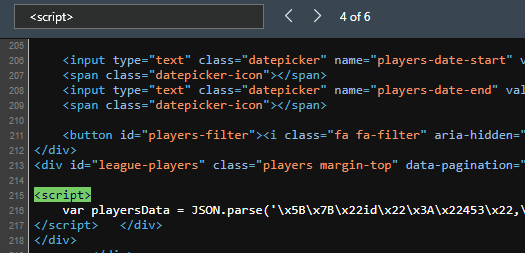

In [4]:
# Fetching data in json format from html

def getdata(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    
    
    # Finding required data
    json_data = soup.find_all('script')[3].string


    # Stripping symbols to clean json data
    index_start = json_data.index("('")+2
    index_end = json_data.index("')")

    json_data = json_data[index_start:index_end]


    # Encoding data for conversion to json format
    json_data = json_data.encode('utf8').decode('unicode_escape')


    # Conversion to json format
    data = json.loads(json_data)
    
    return data

In [5]:
# Converting Json to Pandas Dataframe

player_df = pd.DataFrame(getdata(url))
player_df.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,453,Son Heung-Min,35,3051,23,16.992173850536346,7,7.84695353731513,86,73,2,0,F M,Tottenham,23,16.992173850536346,29.62477569282055,10.343093157745898
1,1250,Mohamed Salah,35,2757,23,24.36429724097252,13,9.79082047007978,139,62,1,0,F S,Liverpool,18,19.797284230589867,32.158807165920734,11.22198199853301
2,2371,Cristiano Ronaldo,30,2468,18,17.212839871644974,3,4.424966126680374,110,26,8,0,F S,Manchester United,15,14.92933338880539,23.25371290743351,7.720640169456601
3,647,Harry Kane,37,3229,17,20.685065291821957,9,9.8182877227664,133,48,5,0,F M S,Tottenham,13,17.640390004962683,31.89218296855688,9.808405855670571
4,838,Sadio Mané,34,2833,16,16.82961391285062,2,5.269158786162734,98,39,5,0,F S,Liverpool,16,16.82961391285062,28.448093853890896,11.072969859465957


In [6]:
# Feature Engineering

def clean_data(player_df):
    
    # Filtering out unncessary features
    player_df = player_df[['player_name', 'team_title', 'games', 'time', 'assists', 'xA', 'key_passes', 'position', 'xGChain', 'xGBuildup']]

    # Converting numerical features to int and float dataype 
    player_df = player_df.astype(
        {
        'games': 'int32',
        'time': 'int32',
        'assists': 'int32',
        'xA': 'float32',
        'key_passes': 'int32',
        'xGChain': 'float32',
        'xGBuildup': 'float32',
        }
    )


    # Filtering out players who have played less than 15 games.
    player_df = player_df.loc[player_df['games']>=15]


    # Deriving per_90 stats
    features = ['assists', 'xA', 'key_passes', 'xGChain', 'xGBuildup']
    for col in features:
        new_col = col+'_90'
        player_df[new_col] = player_df[col]*90/player_df['time']

    player_df.drop(features, axis=1, inplace=True)


    # Keeping only last names
    player_df['player_name'] = player_df['player_name'].apply(lambda x: x.split(' ')[-1])

    return player_df

In [7]:
player_df = clean_data(player_df)
player_df.head()

,player_name,team_title,games,time,position,assists_90,xA_90,key_passes_90,xGChain_90,xGBuildup_90
0,Heung-Min,Tottenham,35,3051,F M,0.206490,0.231474,2.153392,0.873887,0.305106
1,Salah,Liverpool,35,2757,F S,0.424374,0.319613,2.023939,1.049798,0.366332
2,Ronaldo,Manchester United,30,2468,F S,0.109400,0.161364,0.948136,0.847988,0.281547
3,Kane,Tottenham,37,3229,F M S,0.250852,0.273659,1.337876,0.888912,0.273384
4,Mané,Liverpool,34,2833,F S,0.063537,0.167393,1.238969,0.903752,0.351771


# Interesting Findings

### How good are Goalkeepers on the ball?

In [8]:
# Filtering GK
goalies = player_df.loc[player_df['position'].str.contains('GK', case=False)]

# Sorting values by xGChain_90
goalies.sort_values('xGChain_90', ascending=False, inplace=True)
goalies.reset_index(drop=True, inplace=True)
goalies[['player_name', 'team_title', 'key_passes_90','xGChain_90','xGBuildup_90']]

,player_name,team_title,key_passes_90,xGChain_90,xGBuildup_90
0,Ederson,Manchester City,0.000000,0.268999,0.268999
1,Alisson,Liverpool,0.027778,0.263729,0.260171
2,Raya,Brentford,0.041667,0.171701,0.171701
3,Schmeichel,Leicester,0.027027,0.154250,0.153821
4,Mendy,Chelsea,0.000000,0.149627,0.149627
5,Lloris,Tottenham,0.052632,0.143209,0.137780
6,Sánchez,Brighton,0.081081,0.136348,0.128560
7,Meslier,Leeds,0.000000,0.123622,0.123622
8,McCarthy,Southampton,0.058824,0.118171,0.116794
9,Ramsdale,Arsenal,0.000000,0.117524,0.117524


The above table indicates the following -
* 12 out of 21 goalkeepers have passed the ball to a teammate that led to a shot.
* 3 out of those 12 goalkeepers have made an assist
* Teams that play out from the back have goalies with a higher xGChain per 90.

**Now, what is xGChain & xGBuildup?**

xGChain is calculated by finding all the possessions each player is involved in and the corresponding shots within those possessions. The xG is summed and added to each player. Hence, if you started a 30-pass buildup and also took the final shot yourself, value of xGChain will be same.

However, in case of xGBuildup, assists and shots are excluded. Thus, this metric adds more credit to buildup play. For goalkeepers, there is not much difference as they will be hardly participating in the final pass or a shot. Such is the not case though for outfield players.

Reference: [StatsBomb][1]

[1]: https://statsbomb.com/articles/soccer/introducing-xgchain-and-xgbuildup/

### The Pass before the Pass before the Pass...

In [9]:
# Sorting values by xGBuildup_90
player_df.sort_values('xGBuildup_90', ascending=False, inplace=True)
player_df.reset_index(drop=True, inplace=True)

# Filtering out top 50 rows
top_50 = player_df.head(50)

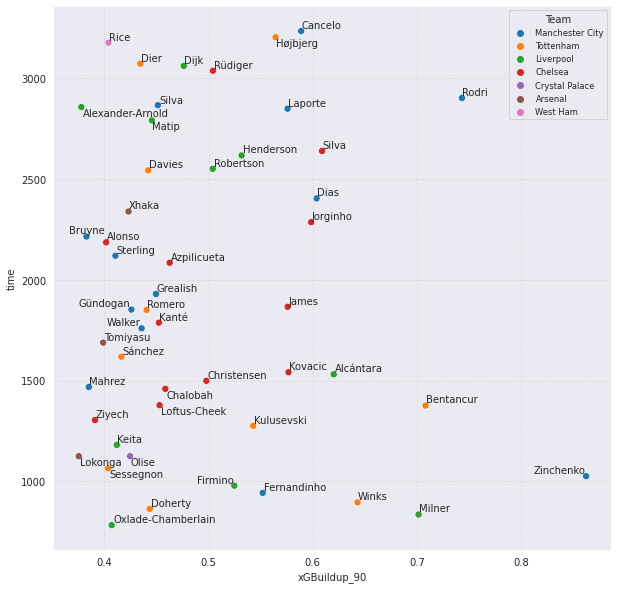

In [10]:
plt.figure(figsize=(10,10))

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

sns.scatterplot(data= top_50, x="xGBuildup_90", y="time", s=50, hue = 'team_title')

plt.legend(loc='upper right', title='Team', fontsize='small')

texts = [plt.text(x_pos, y_pos, f'{l}') for (x_pos, y_pos, l) in zip(top_50["xGBuildup_90"],top_50["time"],top_50["player_name"])]

adjust_text(texts)

plt.show()

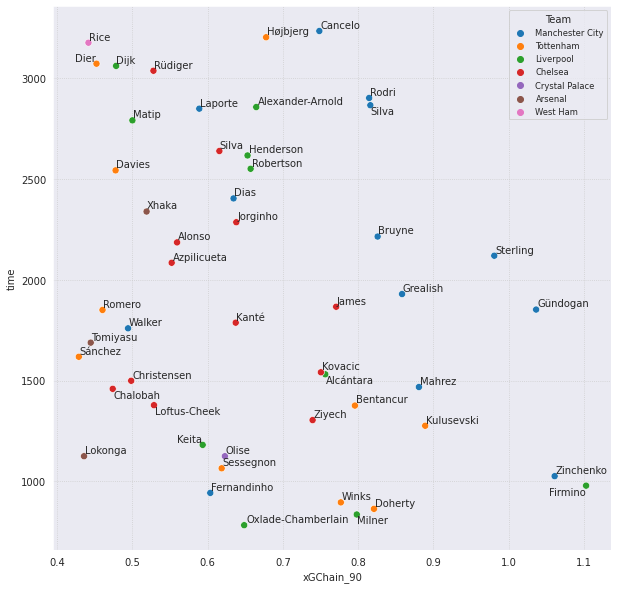

In [11]:
plt.figure(figsize=(10,10))

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

sns.scatterplot(data= top_50, x="xGChain_90", y="time", s=50, hue = 'team_title')

plt.legend(loc='upper right', title='Team', fontsize='small')

texts = [plt.text(x_pos, y_pos, f'{l}') for (x_pos, y_pos, l) in zip(top_50["xGChain_90"],top_50["time"],top_50["player_name"])]

adjust_text(texts)

plt.show()

The above two plots showcases the difference between xGBuildup_90 & xGChain_90 for outfield players.
* For both cases, Rodri, Cancelo, Højbjerg, Thiago Silva, Thiago Alcantara & Bentancur stand out.
* Zinchenko, Milner & Winks are more like outliers due to comparitively lower game time. However, they have a large impact on buildup when involved in the game.

### If I'm fit to play, I'm starting, boss.

In [12]:
# Filtering unused subs
unused_subs = player_df.loc[~player_df['position'].str.contains('S|GK', case=False)]
unused_subs.reset_index(drop=True, inplace=True)
unused_subs[['player_name','team_title','games','time','position']].head(15)

,player_name,team_title,games,time,position
0,Rodri,Manchester City,33,2901,M
1,Cancelo,Manchester City,36,3233,D
2,Laporte,Manchester City,33,2848,D
3,Højbjerg,Tottenham,36,3202,M
4,Rüdiger,Chelsea,34,3036,D
5,Robertson,Liverpool,29,2550,D
6,Dijk,Liverpool,34,3060,D
7,Matip,Liverpool,31,2790,D
8,Walker,Manchester City,20,1759,D
9,Dier,Tottenham,35,3071,D


In [13]:
unused_subs['team_title'].value_counts()

Manchester City                 4
Liverpool                       4
Arsenal                         4
Wolverhampton Wanderers         4
Leeds                           4
Tottenham                       3
Norwich                         3
Burnley                         3
Aston Villa                     3
Brentford                       3
Everton                         2
Watford                         2
Brighton                        2
West Ham                        2
Leicester                       1
Crystal Palace                  1
Aston Villa,Everton             1
Southampton                     1
Chelsea                         1
Aston Villa,Newcastle United    1
Newcastle United                1
Manchester United               1
Name: team_title, dtype: int64

All the above players, even house-hold names such as Son, Trent, Van Dijk, Rudiger and others were never brought on from the bench. If they were rested, they got the full rest. If they were fit, they were surely in the starting line-up.

# Expected Assists
#### (Main focus of the Project)

In [14]:
# Sorting values by xA_90
player_df.sort_values('xA_90', ascending=False, inplace=True)
player_df.reset_index(drop=True, inplace=True)


# Filtering out top 50 rows
top_50 = player_df.head(50)
top_50.head()

,player_name,team_title,games,time,position,assists_90,xA_90,key_passes_90,xGChain_90,xGBuildup_90
0,Bruyne,Manchester City,30,2214,M S,0.325203,0.457731,3.536585,0.825929,0.382679
1,Alexander-Arnold,Liverpool,32,2856,D,0.378151,0.399820,2.836134,0.664642,0.377802
2,Olise,Crystal Palace,26,1125,F M S,0.400000,0.397010,1.920000,0.622966,0.424571
3,James,Chelsea,26,1866,D M S,0.434084,0.339082,2.315113,0.770831,0.575911
4,Salah,Liverpool,35,2757,F S,0.424374,0.319613,2.023939,1.049798,0.366332


In [15]:
fig = px.scatter(top_50, x="xA_90", y="time", text="player_name", color = "team_title")

fig.update_traces(textposition='top center')

fig.update_layout(
    height=1400,
    width=1000,
    title_text=f'Expected Assists vs Minutes Played {leagues[0]}-{str(seasons[-2])}/{str(seasons[-2]+1)}'
)

fig.show()

Unable to fix overlapping annotations in Plotly, I had no option but to switch to Seaborne and the adjustText package to deal with the issue.

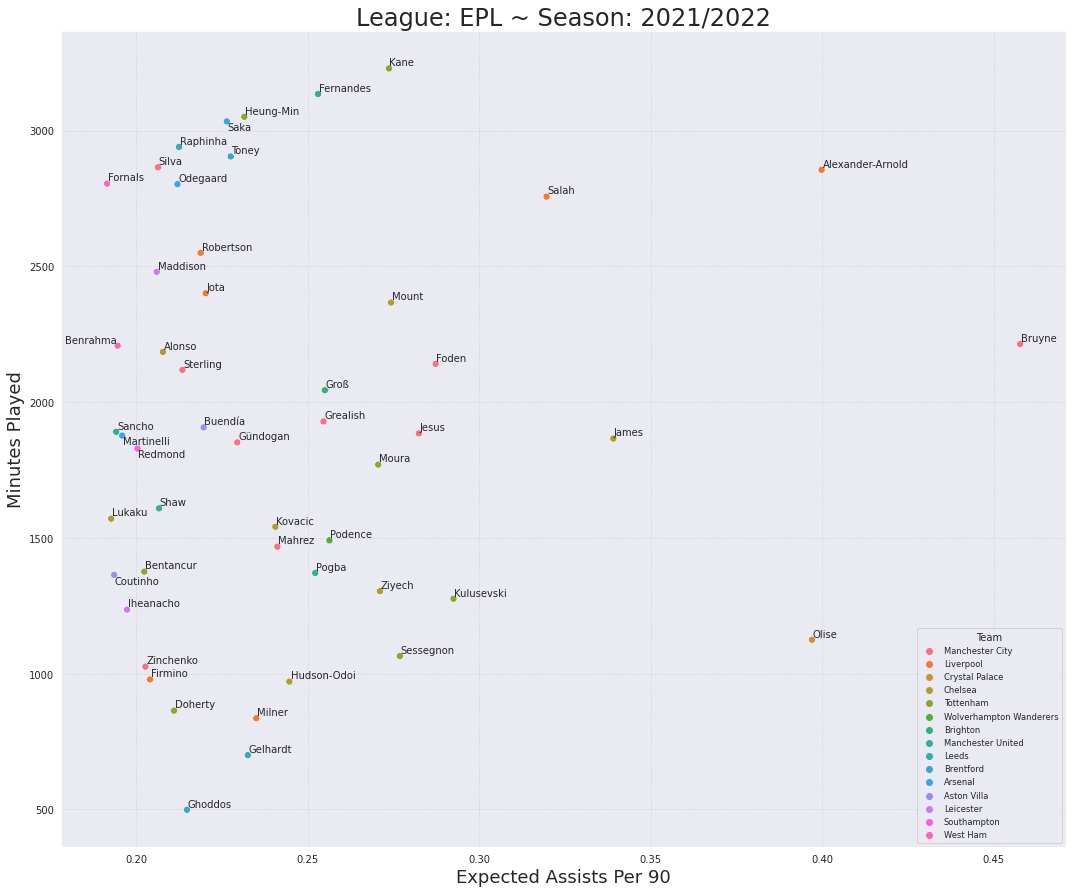

In [16]:
plt.figure(figsize=(18,15))
plt.title(f'League: {leagues[0]} ~ Season: {str(seasons[-2])}/{str(seasons[-2]+1)}', fontsize=24)
plt.xlabel("Expected Assists Per 90", fontsize= 18)
plt.ylabel("Minutes Played", fontsize= 18)

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

sns.scatterplot(data= top_50, x="xA_90", y="time", s=50, hue = 'team_title')

plt.legend(loc='lower right', title='Team', fontsize='small')

texts = [plt.text(x_pos, y_pos, f'{l}') for (x_pos, y_pos, l) in zip(top_50["xA_90"],top_50["time"],top_50["player_name"])]

adjust_text(texts)

plt.show()

Trent, KDB, Salah, James (if fit for whole season) were supposed to be the usual suspects, but it does not rule out the fact how creative they have been in creating chances that can lead directly to a goal.

Mount, Fodden, Jesus and Kane also deserve metion, but the surprise package has been Olise. With not much minutues under his belt, Olise seems to have created several chances, which were expected to be converted. 

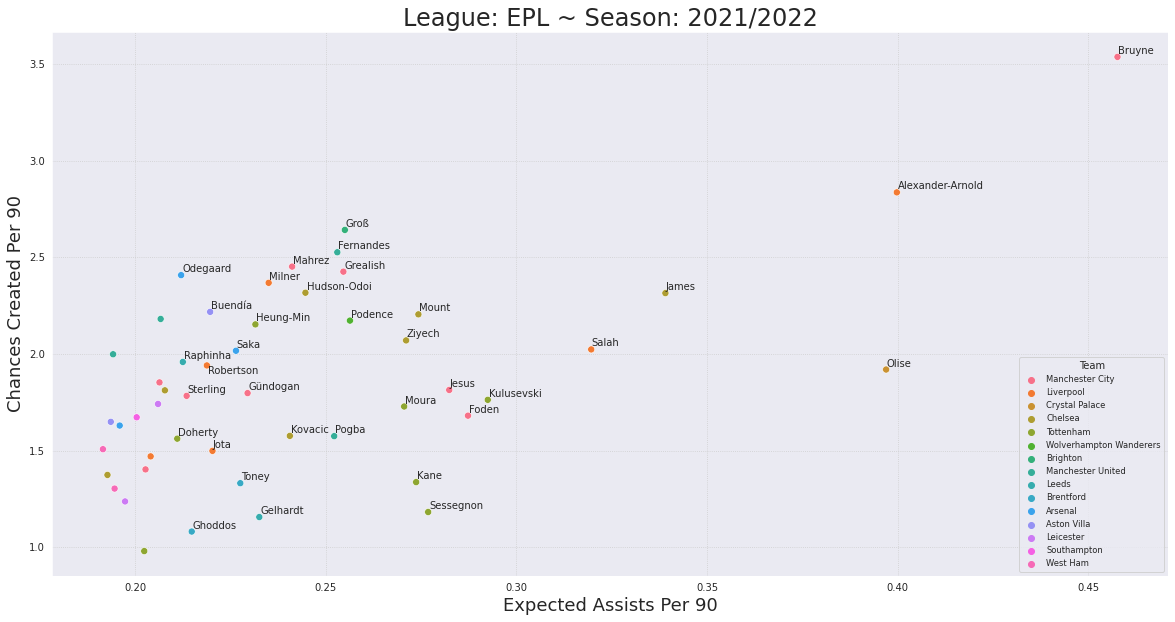

In [17]:
plt.figure(figsize=(20,10))
plt.title(f'League: {leagues[0]} ~ Season: {str(seasons[-2])}/{str(seasons[-2]+1)}', fontsize=24)
plt.xlabel("Expected Assists Per 90", fontsize= 18)
plt.ylabel("Chances Created Per 90", fontsize= 18)

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

sns.scatterplot(data= top_50, x="xA_90", y="key_passes_90", s=50, hue = 'team_title')

plt.legend(loc='lower right', title='Team', fontsize='small')

texts = [plt.text(x_pos, y_pos, f'{l}') for (x_pos, y_pos, l) in zip(top_50["xA_90"],top_50["key_passes_90"],top_50["player_name"][:35])]

adjust_text(texts)

plt.show()

Now, when plotting chances created per 90 (key_passes) on the y axis and xA_90 on x axis, the clear picture comes to the screen. Any pass that leads to a shot is counted as a chance_created or key_pass stat.

Here, we can see Harry Kane not creating a lot of chances compared to others ( mainly due to him being more of a striker) but he is expected to assist more owing to his quality of passing and sheer footballing brilliance. Low chances crated but high probablity they are assists.

The guy at the top-right end of the chart certainly deserves that spot. No wonder KDB bagged the Premiere League 2021-2022 player of the season award. Highest number of chances created in the league added with the highest expected assists per 90 stat.

A big game player.
https://youtu.be/6XFxCBdLpQs?t=264

**Coming Soon:**

*mplsoccer, plotting passes, passing networks and more..*